##### 17.06.24
### Running the normal drift diffusion model on the painreward data from the MPColl Learning and Pain Laboratroy 
### hddm toolbox (© Copyright 2022, Thomas V. Wiecki, Mads Lund Pedersen, Alexander Fengler, Krishn Bera, Michael J. Frank, Brown University. Revision 04854759.)

1. DataFrames:
- subs_concatenated_001_050_3 (this is one of the earlier DataFrames; it contains only participants who accepted less than 99% of the trials; there are no categorical predictors in it yet)

2. Version:
- this code uses hddm version 0.8.0 

3. HDDM Models:
 - simple DDM model that does not allow parameters to vary by condition, 3 chains
 - defining conditions (acceptance_pair(M>P, M=P, P>M), overall value, absolute value, OV_Money_Pain, Abs_Money_Pain)
 - 1) Acceptance_pair model: v varies with M,P,I
 - 2) Acceptance_pair model: v depends on M,P,I - 3 chains
 - 3) Acceptance_pair model where P>M is used as the intercept condition
 - 4) Acceptance_pair model: t depends on M,P,I
 - 5) Acceptance_pair model: a depends on M,P,
 - 6) Acceptance_pair model: a and t depend on M,P,I
 - 7) Acceptance_pair model: v and a depend on M,P,I
 - 8) Acceptance_pair model: v and t depend on M,P,I 
 - 9) Acceptance_pair model: t,v,a depend on M,P,I
 - 10) v varies with OV_value
 - 11) t varies with OV_value
 - 12) a varies with OV_value
 - 13) Abs_value dependent v
 - 14) Abs_value dependent non-decision time
 - 15) Abs_value dependent threshold
 - 16) Abs value Model: a v  vary with absolute value differences
 - 17) Abs value Model: a v t vary with absolute value differences
 - 18) DDM with varying v, t, a and estimated starting point bias
 - 19) Model: OV_Money_Pain, with varying a v t z parameters
 - 20) Model: Abs_Money_Pain, with varying a v t z parameters
 

In [11]:
# importing necessary libs
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import pickle
import matplotlib.pyplot as plt
import matplotlib
from statsmodels.distributions.empirical_distribution import ECDF
import hddm


In [12]:
%matplotlib inline
import hddm
print(hddm.__version__)

0.8.0


In [13]:
# importing the data
data = pd.read_csv('D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/subs_concatenated_001_050_3.csv', sep = ";")
os.makedirs(r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data', exist_ok=True)

model_base_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_simple_fixed_chain_'
trace_base_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/simple_fixed_traces_chain_'

# renaming column headers so they fit the model
data["rt"] = data["choice_resp.rt"]
data["response"] = data["accepted"]
data['moneylevel'] = pd.to_numeric(data['moneylevel'], errors='coerce')
data['painlevel'] = pd.to_numeric(data['painlevel'], errors='coerce')
data['response'] = pd.to_numeric(data['response'], errors='coerce')
data['rt'] = pd.to_numeric(data['rt'], errors='coerce')
data["subj_idx"] = data['participant']

data = data.dropna(subset=['moneylevel', 'painlevel', 'response', 'rt'])

#stim and conf will be defined later

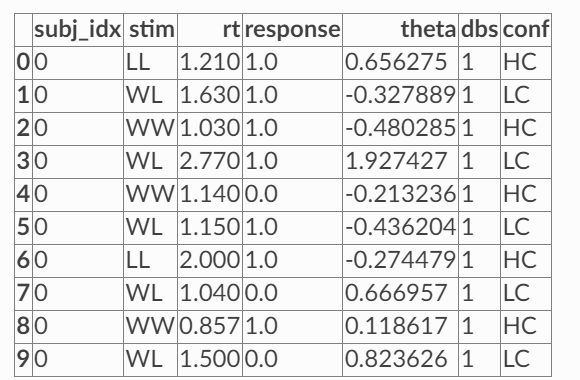

In [4]:
data.head()

,participant,painstim,moneystim,all_trials_rewards,painlevel,painlevel_J,leftstim,rightstim,acceptside,acceptkey,...,P2,P3,P4,P5,fail_ma,fixduration,moneylevel,rt,response,subj_idx
1,sub-002,p1,m2,NaN,1.0,20500.0,stimuli/m2.png,stimuli/p1.png,right,m,...,305.0,415.0,530.0,660.0,700.0,1.8,2.0,1.329101,1.0,sub-002
2,sub-002,p3,m2,NaN,3.0,41500.0,stimuli/p3.png,stimuli/m2.png,right,m,...,305.0,415.0,530.0,660.0,700.0,1.5,2.0,0.919609,1.0,sub-002
3,sub-002,p4,m4,NaN,4.0,53000.0,stimuli/p4.png,stimuli/m4.png,right,m,...,305.0,415.0,530.0,660.0,700.0,1.9,4.0,0.954358,1.0,sub-002
4,sub-002,p4,m2,NaN,4.0,53000.0,stimuli/p4.png,stimuli/m2.png,right,m,...,305.0,415.0,530.0,660.0,700.0,1.6,2.0,1.342306,1.0,sub-002
5,sub-002,p4,m3,NaN,4.0,53000.0,stimuli/p4.png,stimuli/m3.png,right,m,...,305.0,415.0,530.0,660.0,700.0,1.7,3.0,0.874337,1.0,sub-002


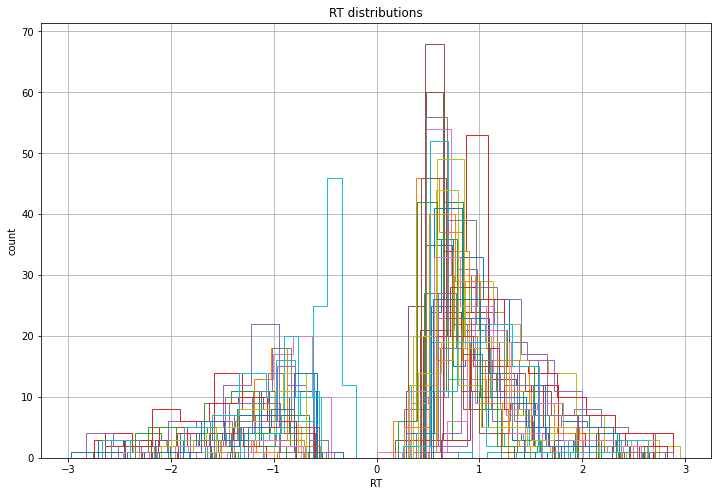

In [5]:
#flipping the sign of RTs for rejected responses
data = hddm.utils.flip_errors(data)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

### simple DDM model that does not allow parameters to vary by condition, 3 chains

In [11]:
m_fixed = hddm.HDDM(data)
m_fixed.find_starting_values()
m_fixed.sample(2000, burn=500)
n_chains = 3

models = []
for i in range(n_chains):
    m_fixed = hddm.HDDM(data)
    m_fixed.find_starting_values()
    db_path = f'{trace_base_path}{i}.db'
    m_fixed.sample(2000, burn=500, dbname=db_path, db='pickle')
    model_path = f'{model_base_path}{i}'
    m_fixed.save(model_path)
    models.append(m_fixed)

gelman = hddm.analyze.gelman_rubin(models)
print('Gelman-Rubin:', gelman)

c:\Users\Asus\anaconda3\envs\hddmJune24\lib\site-packages\scipy\optimize\optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2001 of 2000 complete in 381.9 sec

c:\Users\Asus\anaconda3\envs\hddmJune24\lib\site-packages\scipy\optimize\optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 364.1 sec

c:\Users\Asus\anaconda3\envs\hddmJune24\lib\site-packages\scipy\optimize\optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 376.8 sec

c:\Users\Asus\anaconda3\envs\hddmJune24\lib\site-packages\scipy\optimize\optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2001 of 2000 complete in 354.9 secGelman-Rubin: {'a': 1.0034479438087203, 'a_std': 1.0095821617421101, 'a_subj.sub-002': 1.0110847735377935, 'a_subj.sub-004': 0.9999625266196743, 'a_subj.sub-005': 1.002202650447583, 'a_subj.sub-006': 1.0008163468734974, 'a_subj.sub-007': 0.9997210534240596, 'a_subj.sub-008': 1.0087887266885944, 'a_subj.sub-009': 0.9998423594462796, 'a_subj.sub-010': 1.003407904357239, 'a_subj.sub-011': 1.0083993070258312, 'a_subj.sub-012': 1.0004220611579435, 'a_subj.sub-013': 1.001051682349877, 'a_subj.sub-014': 1.0012702453575733, 'a_subj.sub-015': 1.0000844745850705, 'a_subj.sub-016': 1.001292388191773, 'a_subj.sub-017': 1.0044682925277884, 'a_subj.sub-018': 1.0117599626944287, 'a_subj.sub-019': 1.0013846117136387, 'a_subj.sub-020': 0.99982516851248, 'a_subj.sub-021': 1.0005196850680265, 'a_subj.sub-022': 1.0002690494898603, 'a_subj.sub-023': 1.006752936028986, 'a_subj.sub-024': 1.0000175036772518, 'a_subj.sub-026': 0.999756

In [12]:
m_fixed.print_stats()

                     mean         std        2.5q        25q        50q        75q     97.5q       mc err
a                 1.80126   0.0670263     1.67946    1.75522    1.79709    1.84202   1.94482   0.00281376
a_std            0.368974   0.0637748    0.261742   0.324401   0.363369   0.405639  0.510507   0.00408905
a_subj.sub-002    2.39128    0.259371     1.96451    2.21131    2.36025     2.5448   2.99712    0.0189772
a_subj.sub-004    2.03251     0.11661     1.83691    1.94842    2.02497    2.10707   2.28656   0.00525117
a_subj.sub-005    1.79338   0.0822136     1.63873    1.73691    1.78978    1.84683   1.96547   0.00313472
a_subj.sub-006    1.84079   0.0835103     1.68486    1.78414    1.83889    1.89549   2.01105    0.0030745
a_subj.sub-007     1.5346   0.0648976     1.40757    1.49124    1.53177    1.57756   1.66753   0.00214957
a_subj.sub-008    1.95347    0.228003     1.56535    1.79086    1.93607    2.09063   2.45874    0.0165742
a_subj.sub-009     1.6436    0.105682     1.45

In [16]:
stats = m_fixed.gen_stats()
stats[stats.index.isin(['v', 'v_std', 'v_subj.0', 'v_subj.1'])]


,mean,std,2.5q,25q,50q,75q,97.5q,mc err
v,0.982538,0.146654,0.680091,0.887731,0.982879,1.08061,1.2669,0.00350601
v_std,0.923622,0.10682,0.735895,0.848687,0.917649,0.992822,1.15317,0.00358328


In [17]:
print(stats.index.tolist())


['a', 'a_std', 'a_subj.sub-002', 'a_subj.sub-004', 'a_subj.sub-005', 'a_subj.sub-006', 'a_subj.sub-007', 'a_subj.sub-008', 'a_subj.sub-009', 'a_subj.sub-010', 'a_subj.sub-011', 'a_subj.sub-012', 'a_subj.sub-013', 'a_subj.sub-014', 'a_subj.sub-015', 'a_subj.sub-016', 'a_subj.sub-017', 'a_subj.sub-018', 'a_subj.sub-019', 'a_subj.sub-020', 'a_subj.sub-021', 'a_subj.sub-022', 'a_subj.sub-023', 'a_subj.sub-024', 'a_subj.sub-026', 'a_subj.sub-027', 'a_subj.sub-029', 'a_subj.sub-030', 'a_subj.sub-032', 'a_subj.sub-033', 'a_subj.sub-034', 'a_subj.sub-035', 'a_subj.sub-037', 'a_subj.sub-038', 'a_subj.sub-040', 'a_subj.sub-041', 'a_subj.sub-042', 'a_subj.sub-043', 'a_subj.sub-044', 'a_subj.sub-045', 'a_subj.sub-047', 'a_subj.sub-048', 'a_subj.sub-050', 'v', 'v_std', 'v_subj.sub-002', 'v_subj.sub-004', 'v_subj.sub-005', 'v_subj.sub-006', 'v_subj.sub-007', 'v_subj.sub-008', 'v_subj.sub-009', 'v_subj.sub-010', 'v_subj.sub-011', 'v_subj.sub-012', 'v_subj.sub-013', 'v_subj.sub-014', 'v_subj.sub-015',

Plotting a
Plotting v
Plotting t


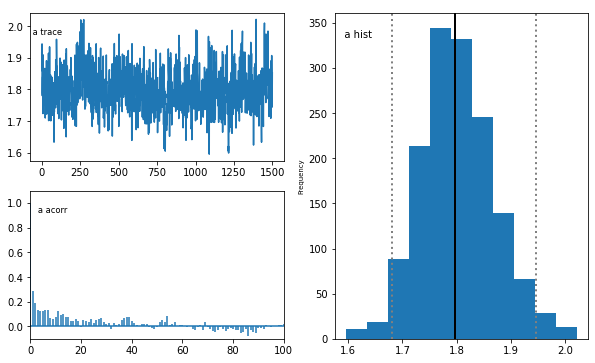

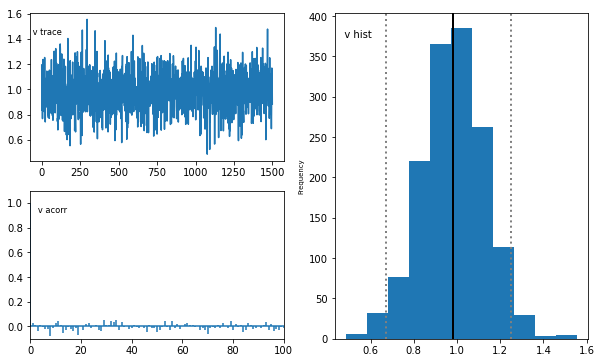

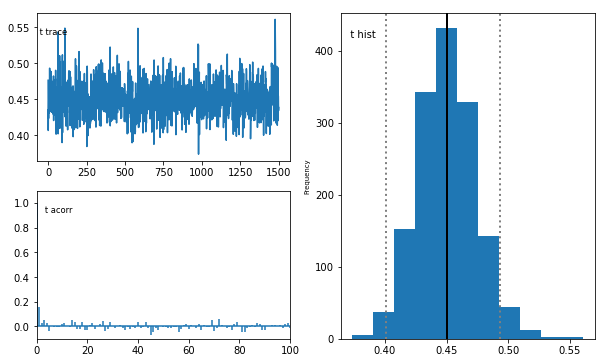

In [15]:
m_fixed.plot_posteriors(['a', 't', 'v'])


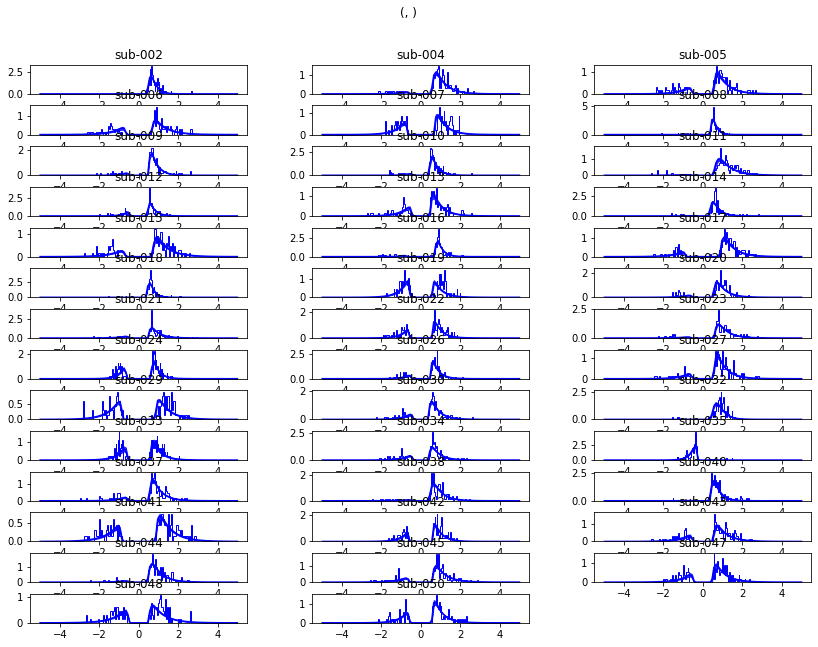

In [18]:
m_fixed.plot_posterior_predictive(figsize=(14, 10))


# Defining Conditions for HDDM and HSSM Analysis

#### 1. Acceptance conditions
- money levels are higher than pain levels (M),
- conditions where both are identical (I), 
- and where pain levels are higher than money levels (P)

In [14]:
# creating stimulus categories to be used in the DDM, the categories are 
stim_categories = []
data['acceptance_pair'] = ''

for index, row in data.iterrows():
    money = row['moneylevel']
    pain = row['painlevel']
    if money == pain:
        category = 'I'
    elif money > pain:
        category = 'M'
    elif money < pain:
        category = 'P'
    stim_categories.append(category)

data['acceptance_pair'] = stim_categories
data.head()

,participant,painstim,moneystim,all_trials_rewards,painlevel,painlevel_J,leftstim,rightstim,acceptside,acceptkey,...,P3,P4,P5,fail_ma,fixduration,moneylevel,rt,response,subj_idx,acceptance_pair
1,sub-002,p1,m2,NaN,1.0,20500.0,stimuli/m2.png,stimuli/p1.png,right,m,...,415.0,530.0,660.0,700.0,1.8,2.0,1.329101,1.0,sub-002,M
2,sub-002,p3,m2,NaN,3.0,41500.0,stimuli/p3.png,stimuli/m2.png,right,m,...,415.0,530.0,660.0,700.0,1.5,2.0,0.919609,1.0,sub-002,P
3,sub-002,p4,m4,NaN,4.0,53000.0,stimuli/p4.png,stimuli/m4.png,right,m,...,415.0,530.0,660.0,700.0,1.9,4.0,0.954358,1.0,sub-002,I
4,sub-002,p4,m2,NaN,4.0,53000.0,stimuli/p4.png,stimuli/m2.png,right,m,...,415.0,530.0,660.0,700.0,1.6,2.0,1.342306,1.0,sub-002,P
5,sub-002,p4,m3,NaN,4.0,53000.0,stimuli/p4.png,stimuli/m3.png,right,m,...,415.0,530.0,660.0,700.0,1.7,3.0,0.874337,1.0,sub-002,P


#### 2. Overall Value (OV) and absolute Value difference (AbsV) after Gluth, Ting, Fontanesi ( recent neuroeconomics papers)
OV = A + B 
 - if (A + B) > 5 OV = high_OV
 - if (A + B) <= 5 OV = low_OV

AbsV = |A| - |B|
 - if (|A| - |B|) < 2 AbsV = low_abs
 - if (|A| - |B|) > 2 AbsV = high_abs
 - if (|A| - |B|) == 2 AbsV = mid_abs


In [15]:
OV_cat= []
Abs_cat= []

data['OV_value'] = ''
data['Abs_value'] = ''

for index, row in data.iterrows():
    money = row['moneylevel']
    pain = row['painlevel']

    if money + pain <=5:
        OV = 'low_OV'
    elif money + pain > 5:
        OV = 'high_OV'
    OV_cat.append(OV)

for index, row in data.iterrows():
    money = row['moneylevel']
    pain = row['painlevel']

    if abs(money - pain) < 2:
        Ab = 'low_abs'
    elif abs(money - pain) > 2:
        Ab = 'high_abs'
    elif abs(money - pain) == 2:
        Ab = 'mid_abs'
    Abs_cat.append(Ab)

data['OV_value'] = OV_cat
data['Abs_value'] = Abs_cat
data.tail()

,participant,painstim,moneystim,all_trials_rewards,painlevel,painlevel_J,leftstim,rightstim,acceptside,acceptkey,...,P5,fail_ma,fixduration,moneylevel,rt,response,subj_idx,acceptance_pair,OV_value,Abs_value
5120,sub-050,p2,m5,NaN,2.0,8500.0,stimuli/m5.png,stimuli/p2.png,right,m,...,200.0,700.0,2.0,5.0,0.608604,1.0,sub-050,M,high_OV,high_abs
5121,sub-050,p3,m3,NaN,3.0,11000.0,stimuli/m3.png,stimuli/p3.png,right,m,...,200.0,700.0,1.5,3.0,0.945931,1.0,sub-050,I,high_OV,low_abs
5122,sub-050,p3,m1,NaN,3.0,11000.0,stimuli/m1.png,stimuli/p3.png,right,m,...,200.0,700.0,1.7,1.0,0.759595,0.0,sub-050,P,low_OV,mid_abs
5123,sub-050,p4,m1,NaN,4.0,14500.0,stimuli/p4.png,stimuli/m1.png,right,m,...,200.0,700.0,1.9,1.0,0.936966,0.0,sub-050,P,low_OV,high_abs
5124,sub-050,p2,m2,NaN,2.0,8500.0,stimuli/p2.png,stimuli/m2.png,right,m,...,200.0,700.0,1.7,2.0,1.334482,1.0,sub-050,I,low_OV,low_abs


### 4) High and low pain and money in OV and Abs value differences

In [17]:
OV_cat= []
Abs_cat= []

data['OV_Money_Pain'] = ''
data['Abs_Money_Pain'] = ''

for index, row in data.iterrows():
    money = row['moneylevel']
    pain = row['painlevel']

    if money + pain > 5 and money > pain:
        OV = 'h_OV_h_money'
    elif money + pain > 5 and pain >= money:
        OV = 'h_OV_h_pain'
    elif money + pain <= 5 and money > pain:
        OV = 'low_OV_h_money'
    elif money + pain <= 5 and pain >= money:
        OV = 'low_OV_h_pain'
    OV_cat.append(OV)

for index, row in data.iterrows():
    money = row['moneylevel']
    pain = row['painlevel']

    if abs(money - pain) < 2 and money > pain:
        Ab = 'low_abs_h_money'
    elif abs(money - pain) < 2 and pain >= money:
        Ab = 'low_abs_h_pain'
    elif abs(money - pain) > 2 and money > pain:
        Ab = 'high_abs_h_money'
    elif abs(money - pain) > 2 and pain >= money:
        Ab = 'high_abs_h_pain'
    elif abs(money - pain) == 2:
        Ab = 'mid_abs'
    Abs_cat.append(Ab)

data['OV_Money_Pain'] = OV_cat
data['Abs_Money_Pain'] = Abs_cat
data.tail()

,participant,painstim,moneystim,all_trials_rewards,painlevel,painlevel_J,leftstim,rightstim,acceptside,acceptkey,...,fixduration,moneylevel,rt,response,subj_idx,acceptance_pair,OV_value,Abs_value,OV_Money_Pain,Abs_Money_Pain
5120,sub-050,p2,m5,NaN,2.0,8500.0,stimuli/m5.png,stimuli/p2.png,right,m,...,2.0,5.0,0.608604,1.0,sub-050,M,high_OV,high_abs,h_OV_h_money,high_abs_h_money
5121,sub-050,p3,m3,NaN,3.0,11000.0,stimuli/m3.png,stimuli/p3.png,right,m,...,1.5,3.0,0.945931,1.0,sub-050,I,high_OV,low_abs,h_OV_h_pain,low_abs_h_pain
5122,sub-050,p3,m1,NaN,3.0,11000.0,stimuli/m1.png,stimuli/p3.png,right,m,...,1.7,1.0,0.759595,0.0,sub-050,P,low_OV,mid_abs,low_OV_h_pain,mid_abs
5123,sub-050,p4,m1,NaN,4.0,14500.0,stimuli/p4.png,stimuli/m1.png,right,m,...,1.9,1.0,0.936966,0.0,sub-050,P,low_OV,high_abs,low_OV_h_pain,high_abs_h_pain
5124,sub-050,p2,m2,NaN,2.0,8500.0,stimuli/p2.png,stimuli/m2.png,right,m,...,1.7,2.0,1.334482,1.0,sub-050,I,low_OV,low_abs,low_OV_h_pain,low_abs_h_pain


## 1) Acceptance_pair DDM model: v depends on M,P,I

In [9]:
os.makedirs(r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data', exist_ok=True)
data['stim'] = data['acceptance_pair']

m_stim = hddm.HDDM(data, depends_on={'v': 'stim'})
m_stim.find_starting_values()
db_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/v_acc_pair_traces.db'
m_stim.sample(2000, burn=500, dbname=db_path, db='pickle')
model_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_v_acceptance_pair'
m_stim.save(model_path)

KeyboardInterrupt: 

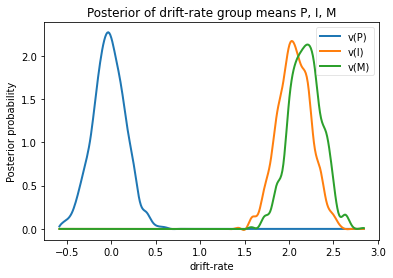

In [30]:
v_Pain, v_Identical, v_Money = m_stim.nodes_db.node[['v(P)', 'v(I)', 'v(M)']]
hddm.analyze.plot_posterior_nodes([v_Pain, v_Identical, v_Money])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means P, I, M')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_v_acceptance_pair.pdf'
plt.savefig(pdf_path)

## 2) Acceptance_pair DDM model: v depends on M,P,I - 3 chains

c:\Users\Asus\anaconda3\envs\hddmJune24\lib\site-packages\scipy\optimize\optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2001 of 2000 complete in 2394.9 sec

c:\Users\Asus\anaconda3\envs\hddmJune24\lib\site-packages\scipy\optimize\optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2001 of 2000 complete in 1922.8 sec

c:\Users\Asus\anaconda3\envs\hddmJune24\lib\site-packages\scipy\optimize\optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 987.1 secGelman-Rubin statistics: {'a': 1.0012621992905855, 'a_std': 1.003047230775376, 'a_subj.sub-002': 1.0030006586545297, 'a_subj.sub-004': 1.0012266536838277, 'a_subj.sub-005': 1.0018557834944324, 'a_subj.sub-006': 1.0002804425983294, 'a_subj.sub-007': 1.0033853799548036, 'a_subj.sub-008': 1.0010341923386759, 'a_subj.sub-009': 1.0031571603514091, 'a_subj.sub-010': 0.9999133731008595, 'a_subj.sub-011': 1.0011943066527467, 'a_subj.sub-012': 1.001333398293355, 'a_subj.sub-013': 0.9998673642123456, 'a_subj.sub-014': 1.00085905134861, 'a_subj.sub-015': 1.0076951303283568, 'a_subj.sub-016': 1.0031572319764868, 'a_subj.sub-017': 1.0006652723980842, 'a_subj.sub-018': 1.0023147652411668, 'a_subj.sub-019': 0.9999183028691345, 'a_subj.sub-020': 1.0005130979185277, 'a_subj.sub-021': 1.0001082762899292, 'a_subj.sub-022': 1.0040201099146664, 'a_subj.sub-023': 0.9998922907332858, 'a_subj.sub-024': 1.0064602406667653, 'a_subj.sub-

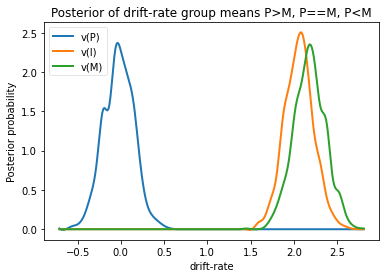

In [31]:

n_chains = 3

model_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_v_acceptance_pair_chain_'
trace_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/v_acc_pair_traces_chain_'

models = []

for i in range(n_chains):
    m_stim = hddm.HDDM(data, depends_on={'v': 'stim'})
    m_stim.find_starting_values()
    db_path = f'{trace_path}{i}.db'
    m_stim.sample(2000, burn=500, dbname=db_path, db='pickle')
    model_p = f'{model_path}{i}'
    m_stim.save(model_p)
    models.append(m_stim)

gelman_rubin_results = hddm.analyze.gelman_rubin(models)
print('Gelman-Rubin statistics:', gelman_rubin_results)

v_Pain, v_Identical, v_Money = models[0].nodes_db.node[['v(P)', 'v(I)', 'v(M)']]
hddm.analyze.plot_posterior_nodes([v_Pain, v_Identical, v_Money])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means P>M, P==M, P<M')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_v_acceptance_pair_2.pdf'
plt.savefig(pdf_path)


In [32]:
m_stim.print_stats()

                         mean        std       2.5q        25q         50q        75q       97.5q       mc err
a                     2.11765  0.0611152     2.0042    2.07842     2.11468    2.15454     2.24298   0.00288661
a_std                0.349463  0.0648335   0.239462   0.302981    0.344161   0.390071    0.488994   0.00457645
a_subj.sub-002        2.43013   0.249357    1.99889    2.25528     2.40012    2.58319     3.03804     0.017903
a_subj.sub-004        2.22727    0.13456    1.97465    2.13634     2.22031    2.31168     2.50582    0.0061893
a_subj.sub-005        2.24678   0.140637    1.98735    2.15135     2.23961     2.3299      2.5351   0.00623446
a_subj.sub-006        2.40665   0.150346    2.13699    2.29892     2.40007    2.50289     2.71805   0.00716722
a_subj.sub-007         2.7144   0.309614    2.19134    2.49269     2.69889    2.90961     3.37443    0.0221348
a_subj.sub-008        1.98501   0.209421    1.63819    1.83011     1.96884    2.12121     2.44069    0.0147518
a

In [33]:
print("P(Money > Pain) = ", (v_Money.trace() > v_Pain.trace()).mean())
print("P(Money > Identical) = ", (v_Money.trace() > v_Identical.trace()).mean())
print("P(Identical > Pain) = ", (v_Identical.trace() > v_Pain.trace()).mean())


P(Money > Pain) =  1.0
P(Money > Identical) =  0.6806666666666666
P(Identical > Pain) =  1.0


In [34]:
data['stim'].value_counts()

M    2035
P    2005
I    1017
Name: stim, dtype: int64

## 3) Acceptance_pair model where P>M is used as the intercept condition

In [35]:
from patsy import dmatrix
dmatrix("C(stim, Treatment('P'))", data.head(10))

DesignMatrix with shape (10, 3)
  Intercept  C(stim, Treatment('P'))[T.I]  C(stim, Treatment('P'))[T.M]
          1                             0                             1
          1                             0                             0
          1                             1                             0
          1                             0                             0
          1                             0                             0
          1                             0                             1
          1                             0                             1
          1                             0                             1
          1                             0                             1
          1                             1                             0
  Terms:
    'Intercept' (column 0)
    "C(stim, Treatment('P'))" (columns 1:3)

In [36]:
path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/v_acc_pair_within.db'

m_within_subj_v = hddm.HDDMRegressor(data, "v ~ C(stim, Treatment('P'))")
m_within_subj_v.sample(2000, burn=100, dbname=path)


Adding these covariates:
['v_Intercept', "v_C(stim, Treatment('P'))[T.I]", "v_C(stim, Treatment('P'))[T.M]"]
 [-----------------100%-----------------] 2001 of 2000 complete in 1475.3 sec

In [37]:
print("Fixed model DIC: %f" % m_fixed.dic)
print("Stim v model DIC: %f" % m_stim.dic)
print("Stim v within model DIC: %f" % m_within_subj_v.dic)


Fixed model DIC: 7667.418861
Stim v model DIC: 5004.011400
Stim v within model DIC: 5483.286146


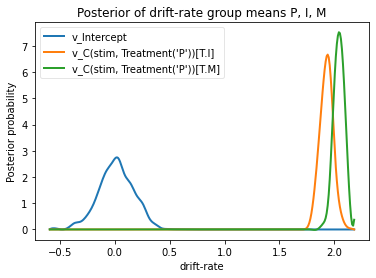

In [39]:
v_P, v_I, v_M = m_within_subj_v.nodes_db.loc[["v_Intercept",
                                              "v_C(stim, Treatment('P'))[T.I]",
                                              "v_C(stim, Treatment('P'))[T.M]"], 'node']
hddm.analyze.plot_posterior_nodes([v_P, v_I, v_M])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means P, I, M')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/v_acc_pair_within.pdf'
plt.savefig(pdf_path)

## 4) Acceptance_pair model: t depends on M,P,I

In [47]:
m_stim_t = hddm.HDDM(data, depends_on={'t': 'stim'})
m_stim_t.find_starting_values()
db_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/t_acc_pair_traces_2.db'
m_stim_t.sample(1000, burn=500, dbname=db_path, db='pickle')
model_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_t_acceptance_pair_2'
m_stim_t.save(model_path)

c:\Users\Asus\anaconda3\envs\hddmJune24\lib\site-packages\scipy\optimize\optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 1001 of 1000 complete in 578.3 sec

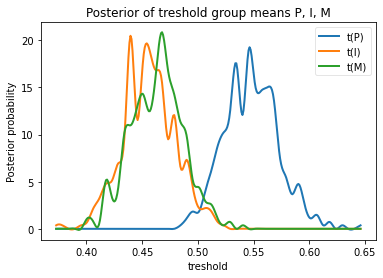

In [48]:
t_P, t_I, t_M = m_stim_t.nodes_db.node[['t(P)', 't(I)', 't(M)']]
hddm.analyze.plot_posterior_nodes([t_P, t_I, t_M])
plt.xlabel('treshold')
plt.ylabel('Posterior probability')
plt.title('Posterior of treshold group means P, I, M')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_t_acceptance_pair.pdf'
plt.savefig(pdf_path)

Plotting t(I)
Plotting t(M)
Plotting t(P)


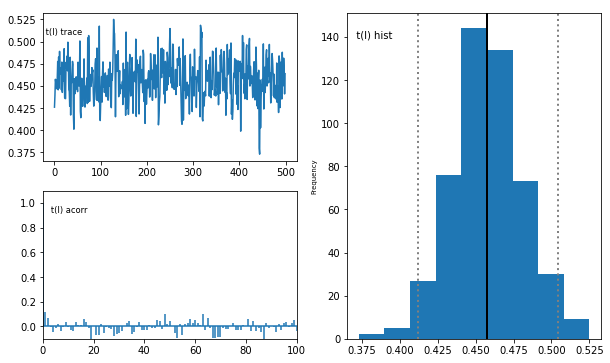

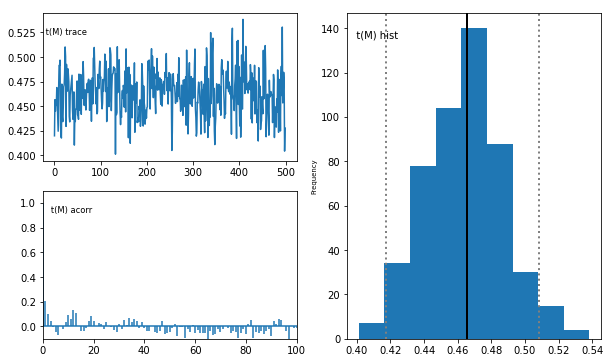

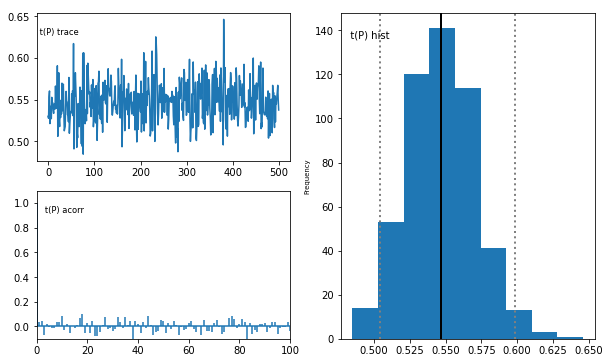

In [54]:
m_stim_t.plot_posteriors(['t'])


In [57]:
stats = m_stim_t.gen_stats()
#stats[stats.index.isin(['t', 't_std', 't_subj.0', 't_subj.1'])]
stats

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.69798,0.0547607,1.60244,1.65882,1.69531,1.73437,1.81674,0.00331748
a_std,0.31245,0.0453594,0.234682,0.281975,0.308063,0.338782,0.420727,0.00324683
a_subj.sub-002,2.21735,0.226002,1.84832,2.04842,2.18628,2.36646,2.72909,0.0196795
a_subj.sub-004,2.02128,0.118777,1.80017,1.94115,2.01067,2.10454,2.25259,0.00822713
a_subj.sub-005,1.67531,0.0835712,1.52501,1.61792,1.67151,1.73587,1.83291,0.00532843
...,...,...,...,...,...,...,...,...
t_subj(P).sub-044,0.600436,0.0296035,0.5291,0.582776,0.602273,0.624285,0.65,0.0019567
t_subj(P).sub-045,0.784724,0.0235062,0.730538,0.770514,0.78732,0.801706,0.821723,0.00119341
t_subj(P).sub-047,0.611325,0.0234768,0.555101,0.600941,0.612582,0.627102,0.651472,0.00142487
t_subj(P).sub-048,0.537864,0.0282497,0.475175,0.520078,0.541962,0.558277,0.58584,0.00146109


In [59]:
print("P(Pain > Money) = ", (t_P.trace() > t_M.trace()).mean())
print("P(Pain > Identical) = ", (t_P.trace() > t_I.trace()).mean())
print("P(Money > Identical) = ", (t_M.trace() > t_I.trace()).mean())

P(Pain > Money) =  0.996
P(Pain > Identical) =  0.994
P(Money > Identical) =  0.586


## 5) Acceptance_pair model: a depends on M,P,I

In [60]:
m_stim_a = hddm.HDDM(data, depends_on={'a': 'stim'})
m_stim_a.find_starting_values()
db_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/t_acc_pair_traces_2.db'
m_stim_a.sample(1000, burn=500, dbname=db_path, db='pickle')
model_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_t_acceptance_pair_2'
m_stim_a.save(model_path)

c:\Users\Asus\anaconda3\envs\hddmJune24\lib\site-packages\scipy\optimize\optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 1000 of 1000 complete in 417.1 sec

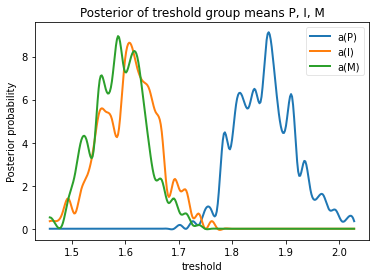

In [61]:
a_P, a_I, a_M = m_stim_a.nodes_db.node[['a(P)', 'a(I)', 'a(M)']]
hddm.analyze.plot_posterior_nodes([a_P, a_I, a_M])
plt.xlabel('treshold')
plt.ylabel('Posterior probability')
plt.title('Posterior of treshold group means P, I, M')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_t_acceptance_pair.pdf'
plt.savefig(pdf_path)

Plotting a(I)
Plotting a(M)
Plotting a(P)


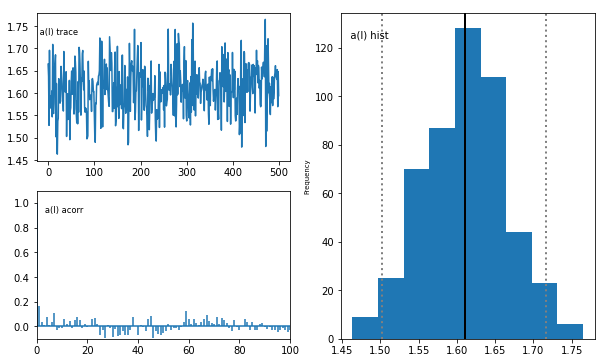

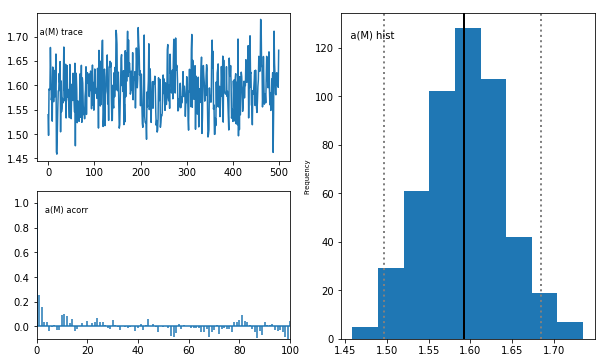

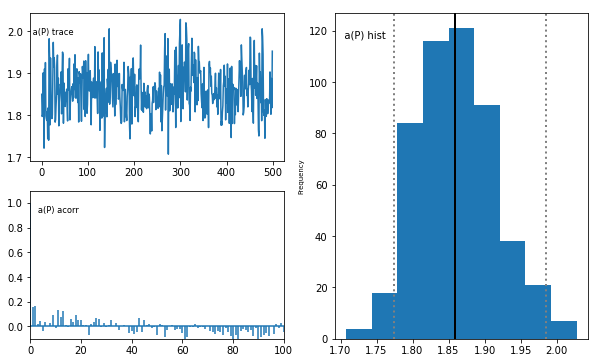

In [62]:
m_stim_a.plot_posteriors(['a'])

In [63]:
print("P(Pain > Money) = ", (a_P.trace() > a_M.trace()).mean())
print("P(Pain > Identical) = ", (a_P.trace() > a_I.trace()).mean())
print("P(Money > Identical) = ", (a_M.trace() > a_I.trace()).mean())

P(Pain > Money) =  1.0
P(Pain > Identical) =  0.998
P(Money > Identical) =  0.394


## 6) Acceptance_pair model: a and t depend on M,P,I

In [64]:
m_stim_a_t = hddm.HDDM(data, depends_on={'a': 'stim', 't': 'stim'})
m_stim_a_t.find_starting_values()
db_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/a_t_acc_pair_traces.db'
m_stim_a_t.sample(1000, burn=500, dbname=db_path, db='pickle')
model_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_a_t_acceptance_pair'
m_stim_a_t.save(model_path)

c:\Users\Asus\anaconda3\envs\hddmJune24\lib\site-packages\scipy\optimize\optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 1001 of 1000 complete in 582.7 sec

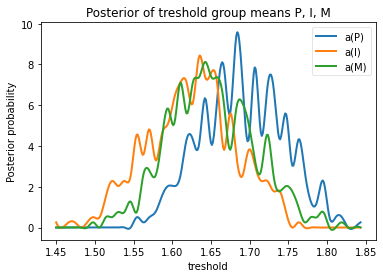

In [67]:
a_P, a_I, a_M = m_stim_a_t.nodes_db.node[['a(P)', 'a(I)', 'a(M)']]
hddm.analyze.plot_posterior_nodes([a_P, a_I, a_M])
plt.xlabel('treshold')
plt.ylabel('Posterior probability')
plt.title('Posterior of treshold group means P, I, M')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_a_t_acceptance_pair.pdf'
plt.savefig(pdf_path)


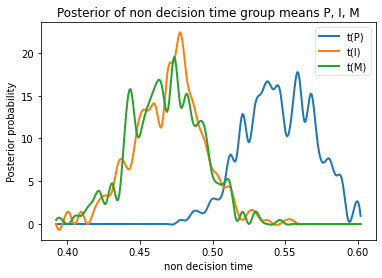

In [73]:
t_P, t_I, t_M = m_stim_a_t.nodes_db.node[['t(P)', 't(I)', 't(M)']]
hddm.analyze.plot_posterior_nodes([t_P, t_I, t_M])
plt.xlabel('non decision time')
plt.ylabel('Posterior probability')
plt.title('Posterior of non decision time group means P, I, M')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_a_t_acceptance_pair_2.pdf'
plt.savefig(pdf_path)

Plotting a(I)
Plotting a(M)
Plotting a(P)


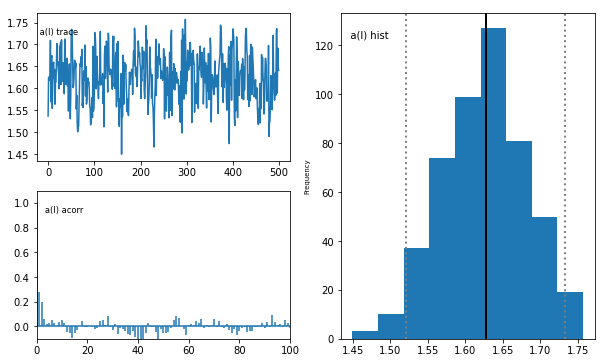

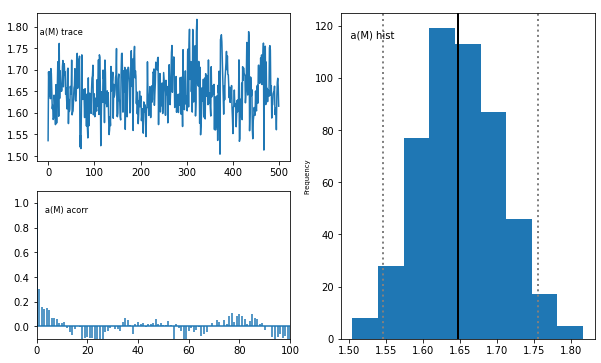

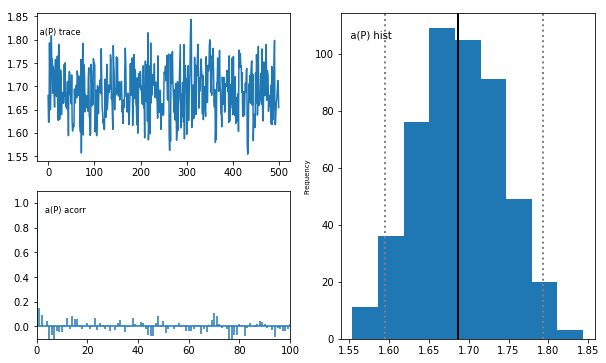

In [68]:
m_stim_a_t.plot_posteriors(['a'])

Plotting t(I)
Plotting t(M)
Plotting t(P)


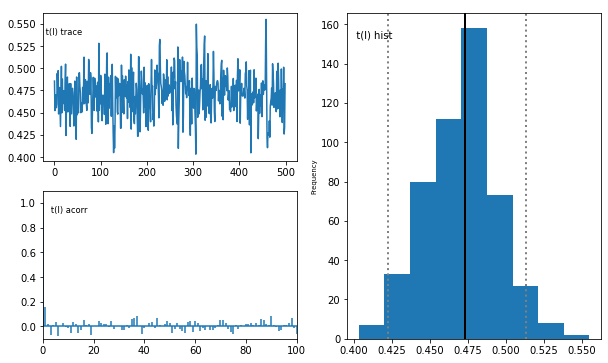

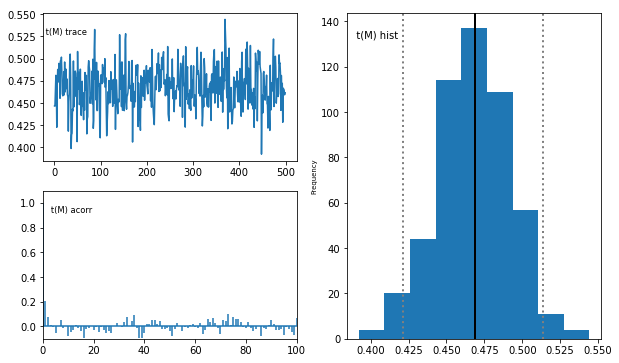

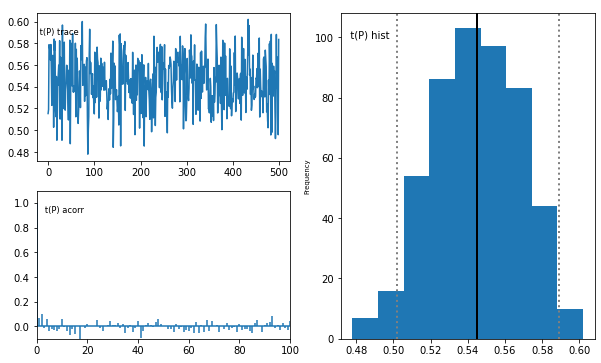

In [70]:
m_stim_a_t.plot_posteriors('t')

## 7) Acceptance_pair model: v and a depend on M,P,I

In [87]:
m_stim_v_a = hddm.HDDM(data, depends_on={'v': 'stim', 'a': 'stim'})
m_stim_v_a.find_starting_values()
db_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/v_a_acc_pair_traces.db'
m_stim_v_a.sample(1000, burn=500, dbname=db_path, db='pickle')
model_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_v_a_acceptance_pair'
m_stim_v_a.save(model_path)

c:\Users\Asus\anaconda3\envs\hddmJune24\lib\site-packages\scipy\optimize\optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 1001 of 1000 complete in 442.4 sec

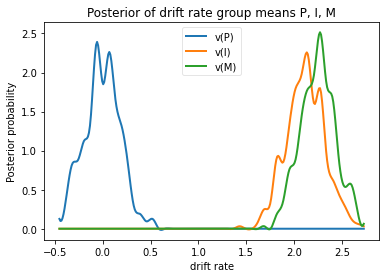

In [88]:
v_P, v_I, v_M = m_stim_v_a.nodes_db.node[['v(P)', 'v(I)', 'v(M)']]
hddm.analyze.plot_posterior_nodes([v_P, v_I, v_M])
plt.xlabel('drift rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate group means P, I, M')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_v_a_acceptance_pair.pdf'
plt.savefig(pdf_path)

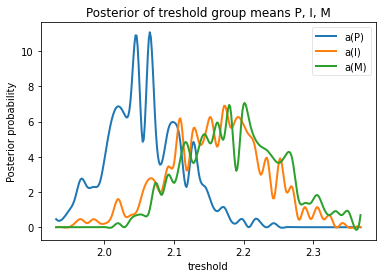

In [90]:
a_P, a_I, a_M = m_stim_v_a.nodes_db.node[['a(P)', 'a(I)', 'a(M)']]
hddm.analyze.plot_posterior_nodes([a_P, a_I, a_M])
plt.xlabel('treshold')
plt.ylabel('Posterior probability')
plt.title('Posterior of treshold group means P, I, M')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_v_a_acceptance_pair_2.pdf'
plt.savefig(pdf_path)

## 8) Acceptance_pair model: v and t depend on M,P,I

In [91]:
m_stim_v_t = hddm.HDDM(data, depends_on={'v': 'stim', 't': 'stim'})
m_stim_v_t.find_starting_values()
db_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/v_t_acc_pair_traces.db'
m_stim_v_t.sample(1000, burn=500, dbname=db_path, db='pickle')
model_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_v_t_acceptance_pair'
m_stim_v_t.save(model_path)

c:\Users\Asus\anaconda3\envs\hddmJune24\lib\site-packages\scipy\optimize\optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 1001 of 1000 complete in 633.2 sec

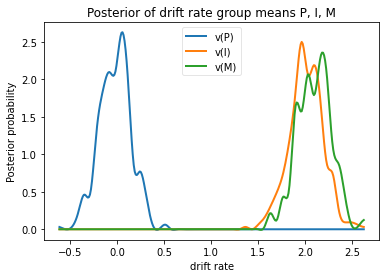

In [92]:
v_P, v_I, v_M = m_stim_v_t.nodes_db.node[['v(P)', 'v(I)', 'v(M)']]
hddm.analyze.plot_posterior_nodes([v_P, v_I, v_M])
plt.xlabel('drift rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate group means P, I, M')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_v_t_acceptance_pair.pdf'
plt.savefig(pdf_path)

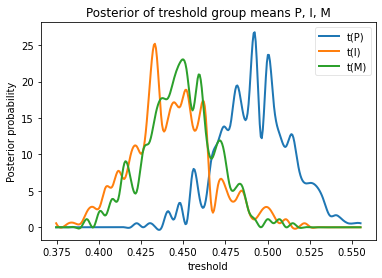

In [93]:
t_P, t_I, t_M = m_stim_v_t.nodes_db.node[['t(P)', 't(I)', 't(M)']]
hddm.analyze.plot_posterior_nodes([t_P, t_I, t_M])
plt.xlabel('treshold')
plt.ylabel('Posterior probability')
plt.title('Posterior of treshold group means P, I, M')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_v_t_acceptance_pair_2.pdf'
plt.savefig(pdf_path)

## 9) Acceptance_pair model: t v a depend on M,P,I

In [74]:
m_stim_a_t_v = hddm.HDDM(data, depends_on={'a': 'stim', 't': 'stim', 'v': 'stim'}, 
                  include={'a', 't', 'v'})
db_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/t_v_a_acc_pair_traces.db'
m_stim_a_t_v.sample(1000, burn=500, dbname=db_path, db='pickle')
model_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_t_v_a_acceptance_pair'
m_stim_a_t_v.save(model_path)

 [-----------------100%-----------------] 1001 of 1000 complete in 1916.3 sec

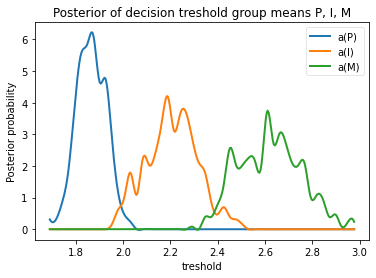

In [77]:
a_P, a_I, a_M = m_stim_a_t_v.nodes_db.node[['a(P)', 'a(I)', 'a(M)']]
hddm.analyze.plot_posterior_nodes([a_P, a_I, a_M])
plt.xlabel('treshold')
plt.ylabel('Posterior probability')
plt.title('Posterior of decision treshold group means P, I, M')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_t_v_a_acceptance_pair_a.pdf'
plt.savefig(pdf_path)

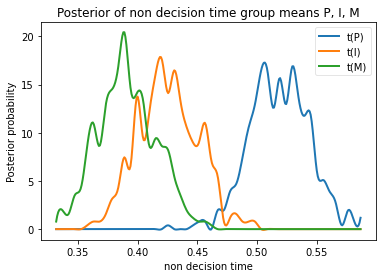

In [78]:
t_P, t_I, t_M = m_stim_a_t_v.nodes_db.node[['t(P)', 't(I)', 't(M)']]
hddm.analyze.plot_posterior_nodes([t_P, t_I, t_M])
plt.xlabel('non decision time')
plt.ylabel('Posterior probability')
plt.title('Posterior of non decision time group means P, I, M')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_t_v_a_acceptance_pair_t.pdf'
plt.savefig(pdf_path)

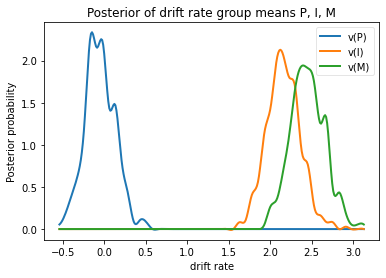

In [79]:
v_P, v_I, v_M = m_stim_a_t_v.nodes_db.node[['v(P)', 'v(I)', 'v(M)']]
hddm.analyze.plot_posterior_nodes([v_P, v_I, v_M])
plt.xlabel('drift rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate group means P, I, M')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_t_v_a_acceptance_pair_v.pdf'
plt.savefig(pdf_path)

Plotting a(I)
Plotting a(M)
Plotting a(P)


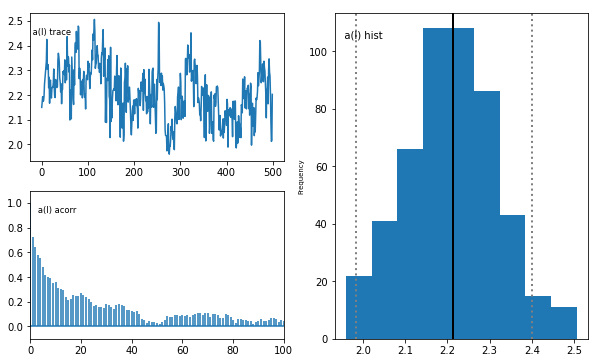

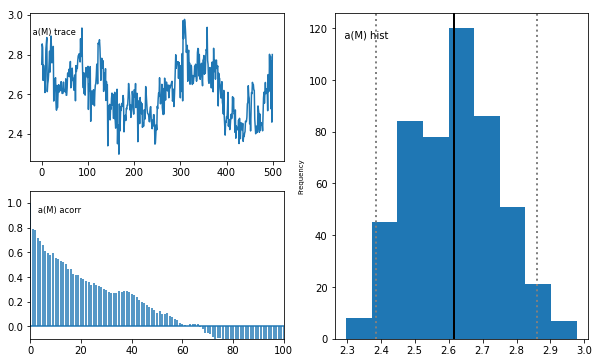

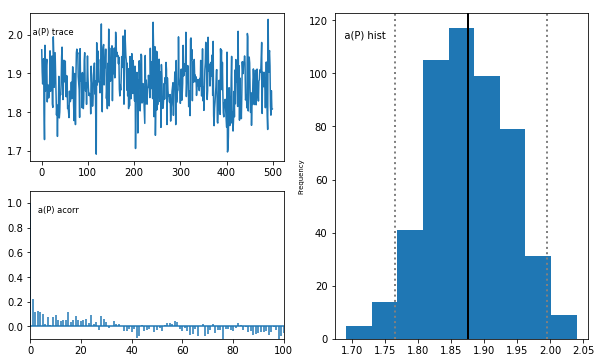

In [84]:
m_stim_a_t_v.plot_posteriors('a')

In [96]:
print("Fixed model DIC: %f" % m_fixed.dic)
print("Stim v model DIC: %f" % m_stim.dic)
print("Stim v within model DIC: %f" % m_within_subj_v.dic)
print("Stim t  model DIC: %f" % m_stim_t.dic)
print("Stim a  model DIC: %f" % m_stim_a.dic)
print("Stim a t model DIC: %f" % m_stim_a_t.dic)
print("Stim v a model DIC: %f" % m_stim_v_a.dic)
print("Stim v t model DIC: %f" % m_stim_v_t.dic)
print("Stim a t v model DIC: %f" % m_stim_a_t_v.dic)


Fixed model DIC: 7667.418861
Stim v model DIC: 5004.011400
Stim v within model DIC: 5483.286146
Stim t  model DIC: 7101.001028
Stim a  model DIC: 7424.966230
Stim a t model DIC: 7072.801970
Stim v a model DIC: 5006.541852
Stim v t model DIC: 4797.647872
Stim a t v model DIC: 4676.902414


#### we can see (from the DIC model comparison above) that the best model is the one where all parameters vary with the acceptance_pair

## Overall (OV) and absolute (Abs) value DDM

## 10): v varies with OV_value

In [100]:
m_OV_v = hddm.HDDM(data, depends_on={'v': 'OV_value'})
db_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/v_OV_traces.db'
m_OV_v.sample(1000, burn=500, dbname=db_path, db='pickle')
model_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_v_OV'
m_OV_v.save(model_path)

 [-----------------100%-----------------] 1001 of 1000 complete in 815.1 sec

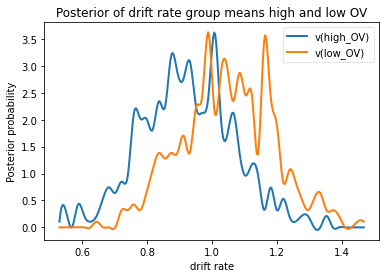

In [101]:
v_OV_high, v_OV_low = m_OV_v.nodes_db.node[['v(high_OV)', 'v(low_OV)']]
hddm.analyze.plot_posterior_nodes([v_OV_high, v_OV_low])
plt.xlabel('drift rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate group means high and low OV')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_OV_v.pdf'
plt.savefig(pdf_path)

Plotting v(high_OV)
Plotting v(low_OV)


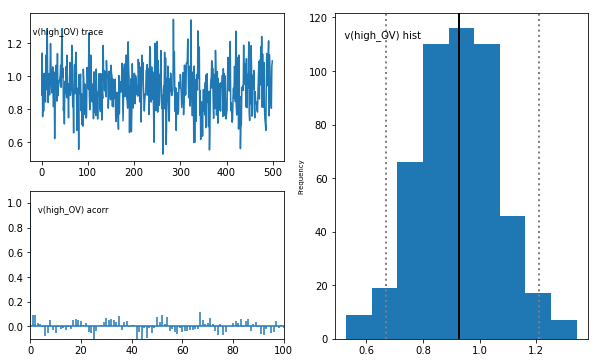

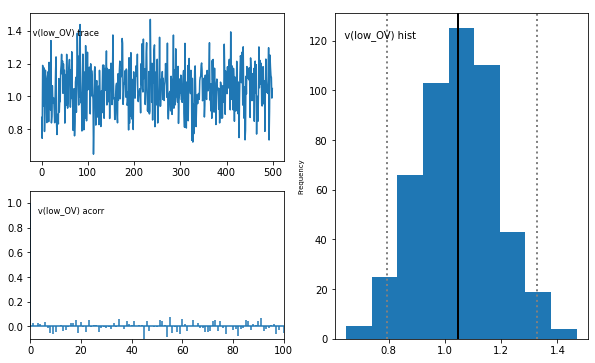

In [102]:
m_OV_v.plot_posteriors('v')

In [104]:
print("P(low_OV > OV_high) = ", (v_OV_low.trace() > v_OV_high.trace()).mean())


P(low_OV > OV_high) =  0.728


## 11) t varies with OV_value

In [16]:
m_OV_t = hddm.HDDM(data, depends_on={'t': 'OV_value'})
db_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/t_OV_traces.db'
m_OV_t.sample(1000, burn=500, dbname=db_path, db='pickle')
model_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_t_OV'
m_OV_t.save(model_path)

 [-----------------100%-----------------] 1001 of 1000 complete in 330.2 sec

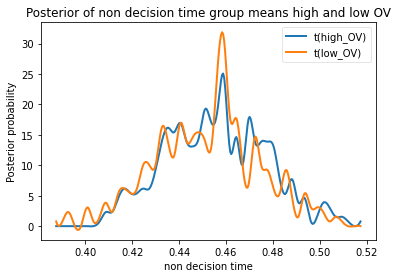

In [22]:
t_OV_high, t_OV_low = m_OV_t.nodes_db.node[['t(high_OV)', 't(low_OV)']]
hddm.analyze.plot_posterior_nodes([t_OV_high, t_OV_low])
plt.xlabel('non decision time')
plt.ylabel('Posterior probability')
plt.title('Posterior of non decision time group means high and low OV')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_OV_v.pdf'
plt.savefig(pdf_path)

## 12) a varies with OV_value

In [21]:
m_OV_a = hddm.HDDM(data, depends_on={'a': 'OV_value'})
db_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/a_OV_traces.db'
m_OV_a.sample(1000, burn=500, dbname=db_path, db='pickle')
model_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_a_OV'
m_OV_a.save(model_path)

 [-----------------100%-----------------] 1000 of 1000 complete in 296.3 sec

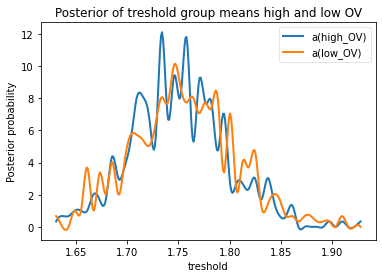

In [23]:
a_OV_high, a_OV_low = m_OV_a.nodes_db.node[['a(high_OV)', 'a(low_OV)']]
hddm.analyze.plot_posterior_nodes([a_OV_high, a_OV_low])
plt.xlabel('treshold')
plt.ylabel('Posterior probability')
plt.title('Posterior of treshold group means high and low OV')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_OV_a.pdf'
plt.savefig(pdf_path)

## Abs value

## 13) Abs_value dependent v

In [13]:
m_abs_v = hddm.HDDM(data, depends_on={'v': 'Abs_value'})
db_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/v_abs_traces.db'
m_abs_v.sample(1000, burn=500, dbname=db_path, db='pickle')
model_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_v_abs'
m_abs_v.save(model_path)

 [-----------------100%-----------------] 1000 of 1000 complete in 413.5 sec

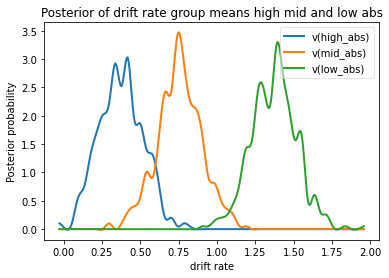

In [17]:
v_abs_high, v_abs_mid, v_abs_low = m_abs_v.nodes_db.node[['v(high_abs)', 'v(mid_abs)', 'v(low_abs)']]
hddm.analyze.plot_posterior_nodes([v_abs_high, v_abs_mid, v_abs_low])
plt.xlabel('drift rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate group means high mid and low abs')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_abs_v.pdf'
plt.savefig(pdf_path)

## 14) Abs_value dependent non-decision time

In [24]:
m_abs_t = hddm.HDDM(data, depends_on={'t': 'Abs_value'})
db_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/t_abs_traces.db'
m_abs_t.sample(1000, burn=500, dbname=db_path, db='pickle')
model_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_t_abs'
m_abs_t.save(model_path)

 [-----------------100%-----------------] 1001 of 1000 complete in 514.0 sec

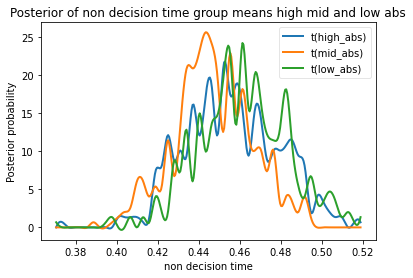

In [26]:
t_abs_high, t_abs_mid, t_abs_low = m_abs_t.nodes_db.node[['t(high_abs)', 't(mid_abs)', 't(low_abs)']]
hddm.analyze.plot_posterior_nodes([t_abs_high, t_abs_mid, t_abs_low])
plt.xlabel('non decision time')
plt.ylabel('Posterior probability')
plt.title('Posterior of non decision time group means high mid and low abs')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_abs_t.pdf'
plt.savefig(pdf_path)

## 15) Abs_value dependent threshold

In [27]:
m_abs_a = hddm.HDDM(data, depends_on={'a': 'Abs_value'})
db_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/a_abs_traces.db'
m_abs_a.sample(1000, burn=500, dbname=db_path, db='pickle')
model_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_a_abs'
m_abs_a.save(model_path)

 [-----------------100%-----------------] 1001 of 1000 complete in 417.8 sec

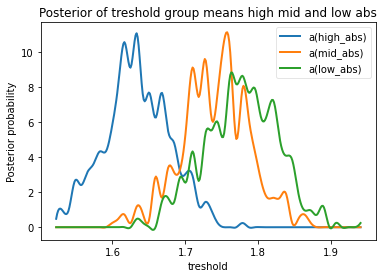

In [28]:
a_abs_high, a_abs_mid, a_abs_low = m_abs_a.nodes_db.node[['a(high_abs)', 'a(mid_abs)', 'a(low_abs)']]
hddm.analyze.plot_posterior_nodes([a_abs_high, a_abs_mid, a_abs_low])
plt.xlabel('treshold')
plt.ylabel('Posterior probability')
plt.title('Posterior of treshold group means high mid and low abs')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_abs_a.pdf'
plt.savefig(pdf_path)

## 16) Abs value Model: a v  vary with absolute value differences

In [29]:
m_abs_a_v = hddm.HDDM(data, depends_on={'a': 'Abs_value', 'v': 'Abs_value'})
db_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/a_v_abs_traces.db'
m_abs_a_v.sample(1000, burn=500, dbname=db_path, db='pickle')
model_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_a_v_abs'
m_abs_a_v.save(model_path)

 [-----------------100%-----------------] 1001 of 1000 complete in 414.2 sec

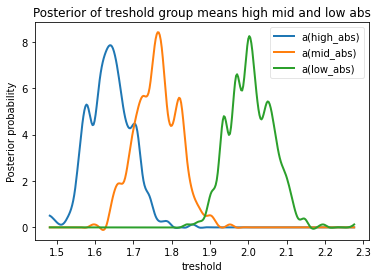

In [30]:
a_abs_high, a_abs_mid, a_abs_low = m_abs_a_v.nodes_db.node[['a(high_abs)', 'a(mid_abs)', 'a(low_abs)']]
hddm.analyze.plot_posterior_nodes([a_abs_high, a_abs_mid, a_abs_low])
plt.xlabel('treshold')
plt.ylabel('Posterior probability')
plt.title('Posterior of treshold group means high mid and low abs')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_abs_a_v.pdf'
plt.savefig(pdf_path)

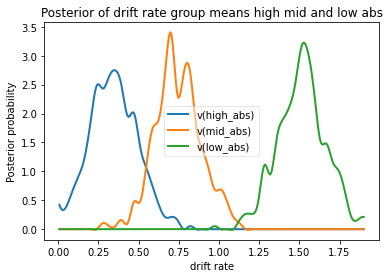

In [31]:
v_abs_high, v_abs_mid, v_abs_low = m_abs_a_v.nodes_db.node[['v(high_abs)', 'v(mid_abs)', 'v(low_abs)']]
hddm.analyze.plot_posterior_nodes([v_abs_high, v_abs_mid, v_abs_low])
plt.xlabel('drift rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate group means high mid and low abs')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_abs_a_v.pdf'
plt.savefig(pdf_path)

## 17) Abs value Model: a v t vary with absolute value differences

In [53]:
m_abs_a_v_t = hddm.HDDM(data, depends_on={'a': 'Abs_value', 'v': 'Abs_value', 't': 'Abs_value'})
db_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/a_v_t_abs_traces.db'
m_abs_a_v_t.sample(1000, burn=500, dbname=db_path, db='pickle')
model_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_a_v_t_abs'
m_abs_a_v_t.save(model_path)

 [-----------------100%-----------------] 1001 of 1000 complete in 1740.8 sec

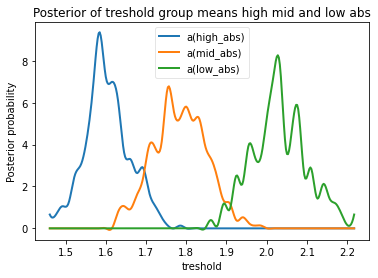

In [54]:
a_abs_high, a_abs_mid, a_abs_low = m_abs_a_v_t.nodes_db.node[['a(high_abs)', 'a(mid_abs)', 'a(low_abs)']]
hddm.analyze.plot_posterior_nodes([a_abs_high, a_abs_mid, a_abs_low])
plt.xlabel('treshold')
plt.ylabel('Posterior probability')
plt.title('Posterior of treshold group means high mid and low abs')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_abs_A_v_t.pdf'
plt.savefig(pdf_path)

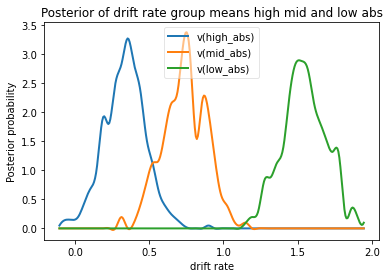

In [55]:
v_abs_high, v_abs_mid, v_abs_low = m_abs_a_v_t.nodes_db.node[['v(high_abs)', 'v(mid_abs)', 'v(low_abs)']]
hddm.analyze.plot_posterior_nodes([v_abs_high, v_abs_mid, v_abs_low])
plt.xlabel('drift rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate group means high mid and low abs')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_abs_a_V_t.pdf'
plt.savefig(pdf_path)

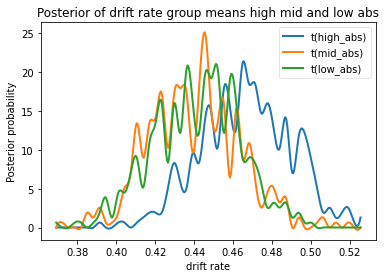

In [56]:
t_abs_high, t_abs_mid, t_abs_low = m_abs_a_v_t.nodes_db.node[['t(high_abs)', 't(mid_abs)', 't(low_abs)']]
hddm.analyze.plot_posterior_nodes([t_abs_high, t_abs_mid, t_abs_low])
plt.xlabel('drift rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate group means high mid and low abs')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_abs_a_v_T.pdf'
plt.savefig(pdf_path)

Plotting t(high_abs)
Plotting t(low_abs)
Plotting t(mid_abs)


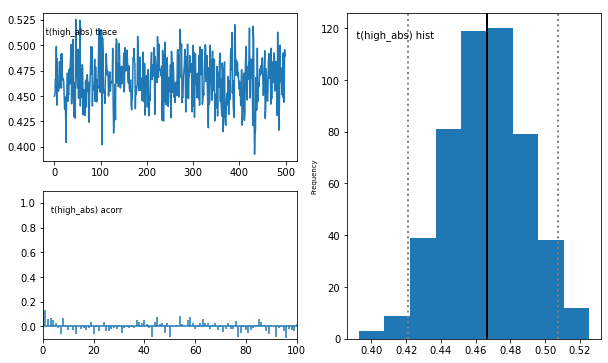

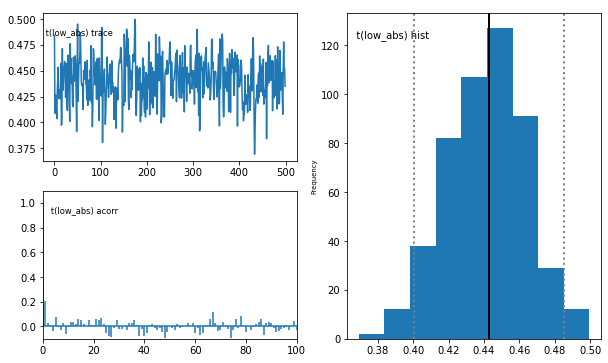

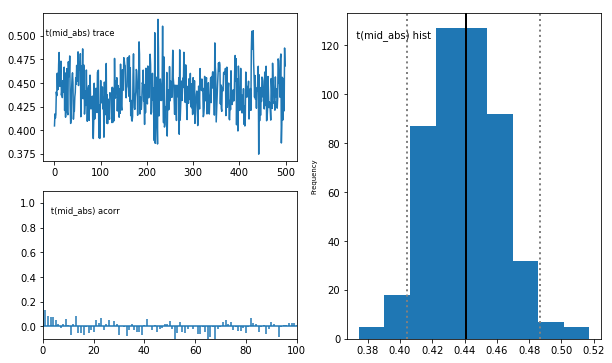

In [59]:
m_abs_a_v_t.plot_posteriors('t')

## Model Comparison

In [52]:
print("m_OV_v DIC: %f" % m_OV_v.dic)
print("m_OV_t DIC: %f" % m_OV_t.dic)
print("m_OV_a DIC: %f" % m_OV_a.dic)
print("m_abs_v DIC: %f" % m_abs_v.dic)
print("m_abs_t DIC: %f" % m_abs_t.dic)
print("m_abs_a DIC: %f" % m_abs_a.dic)
print("m_abs_a_v DIC: %f" % m_abs_a_v.dic)


m_OV_v DIC: 7704.036457
m_OV_t DIC: 7669.129792
m_OV_a DIC: 7722.748339
m_abs_v DIC: 7240.519828
m_abs_t DIC: 7682.374297
m_abs_a DIC: 7704.300143
m_abs_a_v DIC: 7145.145038


In [48]:
import pickle
file = open('D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_v_OV', 'rb')
m_OV_v = pickle.load(file)

In [18]:
data

,participant,painstim,moneystim,all_trials_rewards,painlevel,painlevel_J,leftstim,rightstim,acceptside,acceptkey,...,fixduration,moneylevel,rt,response,subj_idx,acceptance_pair,OV_value,Abs_value,OV_Money_Pain,Abs_Money_Pain
1,sub-002,p1,m2,NaN,1.0,20500.0,stimuli/m2.png,stimuli/p1.png,right,m,...,1.8,2.0,1.329101,1.0,sub-002,M,low_OV,low_abs,low_OV_h_money,low_abs_h_money
2,sub-002,p3,m2,NaN,3.0,41500.0,stimuli/p3.png,stimuli/m2.png,right,m,...,1.5,2.0,0.919609,1.0,sub-002,P,low_OV,low_abs,low_OV_h_pain,low_abs_h_pain
3,sub-002,p4,m4,NaN,4.0,53000.0,stimuli/p4.png,stimuli/m4.png,right,m,...,1.9,4.0,0.954358,1.0,sub-002,I,high_OV,low_abs,h_OV_h_pain,low_abs_h_pain
4,sub-002,p4,m2,NaN,4.0,53000.0,stimuli/p4.png,stimuli/m2.png,right,m,...,1.6,2.0,1.342306,1.0,sub-002,P,high_OV,mid_abs,h_OV_h_pain,mid_abs
5,sub-002,p4,m3,NaN,4.0,53000.0,stimuli/p4.png,stimuli/m3.png,right,m,...,1.7,3.0,0.874337,1.0,sub-002,P,high_OV,low_abs,h_OV_h_pain,low_abs_h_pain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5120,sub-050,p2,m5,NaN,2.0,8500.0,stimuli/m5.png,stimuli/p2.png,right,m,...,2.0,5.0,0.608604,1.0,sub-050,M,high_OV,high_abs,h_OV_h_money,high_abs_h_money
5121,sub-050,p3,m3,NaN,3.0,11000.0,stimuli/m3.png,stimuli/p3.png,right,m,...,1.5,3.0,0.945931,1.0,sub-050,I,high_OV,low_abs,h_OV_h_pain,low_abs_h_pain
5122,sub-050,p3,m1,NaN,3.0,11000.0,stimuli/m1.png,stimuli/p3.png,right,m,...,1.7,1.0,0.759595,0.0,sub-050,P,low_OV,mid_abs,low_OV_h_pain,mid_abs
5123,sub-050,p4,m1,NaN,4.0,14500.0,stimuli/p4.png,stimuli/m1.png,right,m,...,1.9,1.0,0.936966,0.0,sub-050,P,low_OV,high_abs,low_OV_h_pain,high_abs_h_pain


In [19]:
OV_cat= []
Abs_cat= []
data['OV_Money_Pain'] = ''
data['Abs_Money_Pain'] = ''

for index, row in data.iterrows():
    money = row['moneylevel']
    pain = row['painlevel']

    if money + pain > 5 and money > pain:
        OV = 'h_OV_h_money'
    elif money + pain > 5 and pain >= money:
        OV = 'h_OV_h_pain'
    elif money + pain <= 5 and money > pain:
        OV = 'low_OV_h_money'
    elif money + pain <= 5 and pain >= money:
        OV = 'low_OV_h_pain'
    OV_cat.append(OV)

for index, row in data.iterrows():
    money = row['moneylevel']
    pain = row['painlevel']

    if abs(money - pain) < 2 and money > pain:
        Ab = 'low_abs_h_money'
    elif abs(money - pain) < 2 and pain >= money:
        Ab = 'low_abs_h_pain'
    elif abs(money - pain) > 2 and money > pain:
        Ab = 'high_abs_h_money'
    elif abs(money - pain) > 2 and pain >= money:
        Ab = 'high_abs_h_pain'
    elif abs(money - pain) == 2:
        Ab = 'mid_abs'
    Abs_cat.append(Ab)

data['OV_Money_Pain'] = OV_cat
data['Abs_Money_Pain'] = Abs_cat
data.tail()

,participant,painstim,moneystim,all_trials_rewards,painlevel,painlevel_J,leftstim,rightstim,acceptside,acceptkey,...,fixduration,moneylevel,rt,response,subj_idx,acceptance_pair,OV_value,Abs_value,OV_Money_Pain,Abs_Money_Pain
5120,sub-050,p2,m5,NaN,2.0,8500.0,stimuli/m5.png,stimuli/p2.png,right,m,...,2.0,5.0,0.608604,1.0,sub-050,M,high_OV,high_abs,h_OV_h_money,high_abs_h_money
5121,sub-050,p3,m3,NaN,3.0,11000.0,stimuli/m3.png,stimuli/p3.png,right,m,...,1.5,3.0,0.945931,1.0,sub-050,I,high_OV,low_abs,h_OV_h_pain,low_abs_h_pain
5122,sub-050,p3,m1,NaN,3.0,11000.0,stimuli/m1.png,stimuli/p3.png,right,m,...,1.7,1.0,0.759595,0.0,sub-050,P,low_OV,mid_abs,low_OV_h_pain,mid_abs
5123,sub-050,p4,m1,NaN,4.0,14500.0,stimuli/p4.png,stimuli/m1.png,right,m,...,1.9,1.0,0.936966,0.0,sub-050,P,low_OV,high_abs,low_OV_h_pain,high_abs_h_pain
5124,sub-050,p2,m2,NaN,2.0,8500.0,stimuli/p2.png,stimuli/m2.png,right,m,...,1.7,2.0,1.334482,1.0,sub-050,I,low_OV,low_abs,low_OV_h_pain,low_abs_h_pain


In [18]:
data['OV_Money_Pain']

1       low_OV_h_money
2        low_OV_h_pain
3          h_OV_h_pain
4          h_OV_h_pain
5          h_OV_h_pain
             ...      
5120      h_OV_h_money
5121       h_OV_h_pain
5122     low_OV_h_pain
5123     low_OV_h_pain
5124     low_OV_h_pain
Name: OV_Money_Pain, Length: 5057, dtype: object

In [20]:
data.to_csv('D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/subs_concatenated_001_050_5.csv')


### hierarchical model that estimates separate drift rates (v) as a function of task condition, denoted by the “stim” column, and moreover estimates the starting point bias z

In [12]:
z_bias_model_v = hddm.HDDM(data, include = ['z'], depends_on = {'v': ['stim']})

db_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/z_bias_model_v_traces.db'
z_bias_model_v.sample(1000, burn=500, dbname=db_path, db='pickle')
model_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_z_bias_v'
z_bias_model_v.save(model_path)

 [-----------------100%-----------------] 1001 of 1000 complete in 624.7 sec

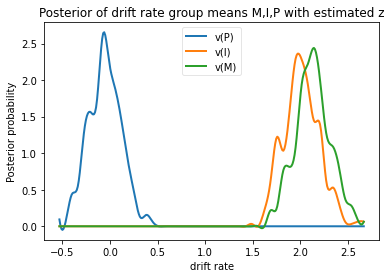

In [14]:
v_P, v_I, v_M = z_bias_model_v.nodes_db.node[['v(P)', 'v(I)', 'v(M)']]
hddm.analyze.plot_posterior_nodes([v_P, v_I, v_M])
plt.xlabel('drift rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate group means M,I,P with estimated z')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_z_bias_v.pdf'
plt.savefig(pdf_path)

### DDM with varying v, t, and estimated starting point bias

In [15]:
z_bias_model_v_t = hddm.HDDM(data, include = ['z'], depends_on = {'v': ['stim'], 't': ['stim']})

db_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/z_bias_model_v_t_traces.db'
z_bias_model_v_t.sample(1000, burn=500, dbname=db_path, db='pickle')
model_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_z_bias_v_t'
z_bias_model_v_t.save(model_path)

 [-----------------100%-----------------] 1001 of 1000 complete in 2497.7 sec

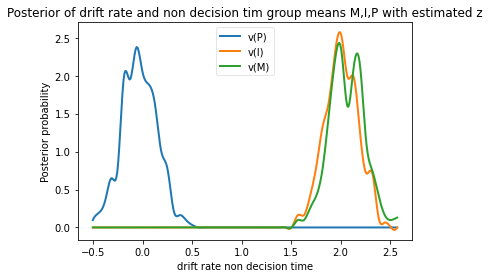

In [16]:
v_P, v_I, v_M = z_bias_model_v_t.nodes_db.node[['v(P)', 'v(I)', 'v(M)']]
hddm.analyze.plot_posterior_nodes([v_P, v_I, v_M])
plt.xlabel('drift rate non decision time')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate and non decision tim group means M,I,P with estimated z')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_z_bias_v_t.pdf'
plt.savefig(pdf_path)

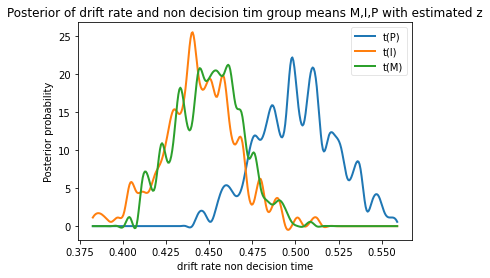

In [17]:
t_P, t_I, t_M = z_bias_model_v_t.nodes_db.node[['t(P)', 't(I)', 't(M)']]
hddm.analyze.plot_posterior_nodes([t_P, t_I, t_M])
plt.xlabel('drift rate non decision time')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate and non decision tim group means M,I,P with estimated z')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_z_bias_v_t_2.pdf'
plt.savefig(pdf_path)

## 18) DDM with varying v, t, a and estimated starting point bias

In [19]:
z_bias_model_v_t_a = hddm.HDDM(data, include = ['z'], depends_on = {'v': ['stim'], 't': ['stim'], 'a': ['stim']})

db_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/z_bias_model_v_t_a_traces.db'
z_bias_model_v_t_a.sample(1000, burn=500, dbname=db_path, db='pickle')
model_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_z_bias_v_t_a'
z_bias_model_v_t_a.save(model_path)

 [-----------------100%-----------------] 1001 of 1000 complete in 1826.6 sec

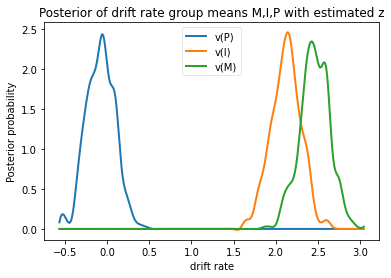

In [20]:
v_P, v_I, v_M = z_bias_model_v_t_a.nodes_db.node[['v(P)', 'v(I)', 'v(M)']]
hddm.analyze.plot_posterior_nodes([v_P, v_I, v_M])
plt.xlabel('drift rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate group means M,I,P with estimated z')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_z_bias_v_t_a.pdf'
plt.savefig(pdf_path)

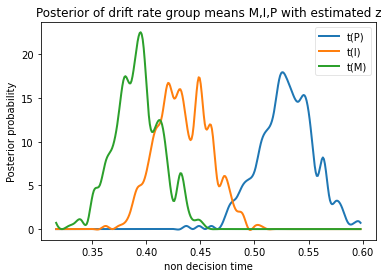

In [21]:
t_P, t_I, t_M = z_bias_model_v_t_a.nodes_db.node[['t(P)', 't(I)', 't(M)']]
hddm.analyze.plot_posterior_nodes([t_P, t_I, t_M])
plt.xlabel('non decision time')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate group means M,I,P with estimated z')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_z_bias_v_t_a_2.pdf'
plt.savefig(pdf_path)

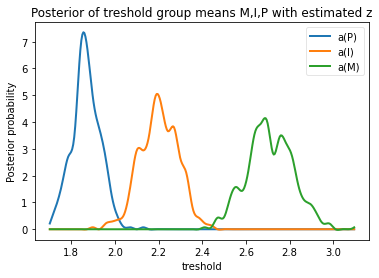

In [22]:
a_P, a_I, a_M = z_bias_model_v_t_a.nodes_db.node[['a(P)', 'a(I)', 'a(M)']]
hddm.analyze.plot_posterior_nodes([a_P, a_I, a_M])
plt.xlabel('treshold')
plt.ylabel('Posterior probability')
plt.title('Posterior of treshold group means M,I,P with estimated z')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_z_bias_v_t_a_3.pdf'
plt.savefig(pdf_path)

 v, t, a, z vary

In [ ]:
m_v_t_a_z = hddm.HDDM(data, depends_on = {'v': ['stim'], 't': ['stim'], 'a': ['stim'], 'z': ['stim']})

db_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/m_v_t_a_z_traces.db'
m_v_t_a_z.sample(1000, burn=500, dbname=db_path, db='pickle')
model_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_m_v_t_a_z'
m_v_t_a_z.save(model_path)

## 19) Model: OV_Money_Pain, with varying a v t z parameters

### 
1. trials where either money levels are higher than pain levels when OV is high: h_OV_h_money,
2.  where pain levels are higher than moeny levels when OV is high: h_OV_h_pain, 
3. where moeny levels are higher than pain levels when OV is low: low_OV_h_money, 
4. trials where pain levels are higher than money levels wehn OV is low: low_OV_h_pain

In [26]:
m_OV_Money_Pain_a_v_t_z = hddm.HDDM(data, depends_on={'a': ['OV_Money_Pain'], 'v': ['OV_Money_Pain'], 't': ['OV_Money_Pain'], 'z': ['OV_Money_Pain']})
db_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/m_OV_Money_Pain_a_v_t_z_traces.db'
m_OV_Money_Pain_a_v_t_z.sample(1000, burn=500, dbname=db_path, db='pickle')
model_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_modelOV_Money_Pain_a_v_t_z'
m_OV_Money_Pain_a_v_t_z.save(model_path)

 [-----------------100%-----------------] 1001 of 1000 complete in 850.7 sec

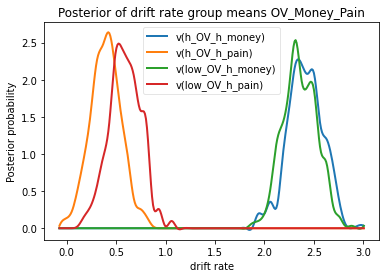

In [28]:
v_hovhm, v_hovhp, v_lovhm, v_lovhp = m_OV_Money_Pain_a_v_t_z.nodes_db.node[['v(h_OV_h_money)', 'v(h_OV_h_pain)', 'v(low_OV_h_money)', 'v(low_OV_h_pain)']]
hddm.analyze.plot_posterior_nodes([v_hovhm, v_hovhp, v_lovhm, v_lovhp])
plt.xlabel('drift rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate group means OV_Money_Pain')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_OV_Money_Pain_a_v_t_z.pdf'
plt.savefig(pdf_path)


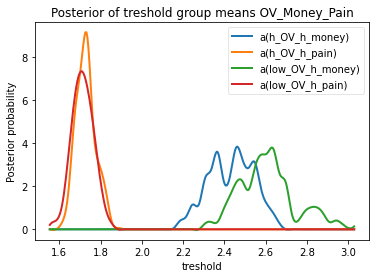

In [30]:
a_hovhm, a_hovhp, a_lovhm, a_lovhp = m_OV_Money_Pain_a_v_t_z.nodes_db.node[['a(h_OV_h_money)', 'a(h_OV_h_pain)', 'a(low_OV_h_money)', 'a(low_OV_h_pain)']]
hddm.analyze.plot_posterior_nodes([a_hovhm, a_hovhp, a_lovhm, a_lovhp])
plt.xlabel('treshold')
plt.ylabel('Posterior probability')
plt.title('Posterior of treshold group means OV_Money_Pain')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_OV_Money_Pain_a_v_t_z_2.pdf'
plt.savefig(pdf_path)


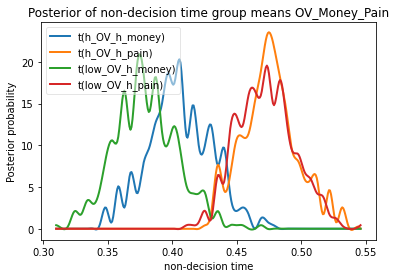

In [31]:
t_hovhm, t_hovhp, t_lovhm, t_lovhp = m_OV_Money_Pain_a_v_t_z.nodes_db.node[['t(h_OV_h_money)', 't(h_OV_h_pain)', 't(low_OV_h_money)', 't(low_OV_h_pain)']]
hddm.analyze.plot_posterior_nodes([t_hovhm, t_hovhp, t_lovhm, t_lovhp])
plt.xlabel('non-decision time')
plt.ylabel('Posterior probability')
plt.title('Posterior of non-decision time group means OV_Money_Pain')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_OV_Money_Pain_a_v_t_z_3.pdf'
plt.savefig(pdf_path)


## 20) Model: Abs_Money_Pain, with varying a v t z parameters

In [33]:
m_Abs_Money_Pain_a_v_t_z = hddm.HDDM(data, depends_on={'a': ['Abs_Money_Pain'], 'v': ['Abs_Money_Pain'], 't': ['Abs_Money_Pain']})
db_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/m_Abs_Money_Pain_a_v_t_z_traces.db'
m_Abs_Money_Pain_a_v_t_z.sample(1000, burn=500, dbname=db_path, db='pickle')
model_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_Abs_Money_Pain_a_v_t_z'
m_Abs_Money_Pain_a_v_t_z.save(model_path)

 [-----------------100%-----------------] 1001 of 1000 complete in 1213.2 sec

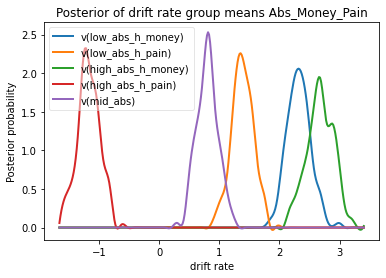

In [35]:
v_lahm, v_lahp, v_hahm, v_hahp, v_mid = m_Abs_Money_Pain_a_v_t_z.nodes_db.node[['v(low_abs_h_money)', 'v(low_abs_h_pain)', 'v(high_abs_h_money)', 'v(high_abs_h_pain)', 'v(mid_abs)']]
hddm.analyze.plot_posterior_nodes([v_lahm, v_lahp, v_hahm, v_hahp, v_mid])
plt.xlabel('drift rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate group means Abs_Money_Pain')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_Abs_Money_a_v_t.pdf'
plt.savefig(pdf_path)



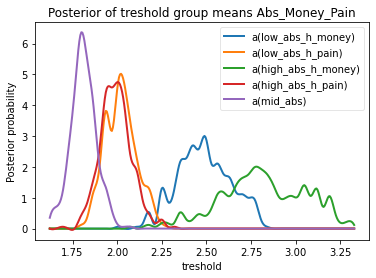

In [37]:
a_lahm, a_lahp, a_hahm, a_hahp, a_mid = m_Abs_Money_Pain_a_v_t_z.nodes_db.node[['a(low_abs_h_money)', 'a(low_abs_h_pain)', 'a(high_abs_h_money)', 'a(high_abs_h_pain)', 'a(mid_abs)']]
hddm.analyze.plot_posterior_nodes([a_lahm, a_lahp, a_hahm, a_hahp, a_mid])
plt.xlabel('treshold')
plt.ylabel('Posterior probability')
plt.title('Posterior of treshold group means Abs_Money_Pain')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_Abs_Money_a_v_t_2.pdf'
plt.savefig(pdf_path)



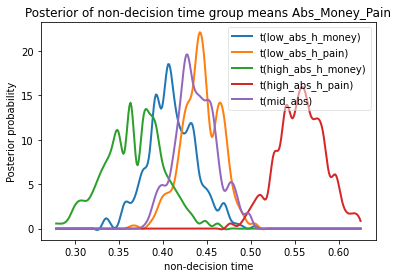

In [38]:
t_lahm, t_lahp, t_hahm, t_hahp, t_mid = m_Abs_Money_Pain_a_v_t_z.nodes_db.node[['t(low_abs_h_money)', 't(low_abs_h_pain)', 't(high_abs_h_money)', 't(high_abs_h_pain)', 't(mid_abs)']]
hddm.analyze.plot_posterior_nodes([t_lahm, t_lahp, t_hahm, t_hahp, t_mid])
plt.xlabel('non-decision time')
plt.ylabel('Posterior probability')
plt.title('Posterior of non-decision time group means Abs_Money_Pain')
pdf_path = r'D:/Aberdeen_Uni_June24/MPColl_Lab/Week3/HSSM/data/hddm_model_Abs_Money_a_v_t_3.pdf'
plt.savefig(pdf_path)



AttributeError: module 'hddm' has no attribute 'plotting'